# External Forcing Plots in Sigma-P Coordinates

## Import libraries

Standard library

In [1]:
# import warnings
from operator import itemgetter

# warnings.filterwarnings("ignore")

External libraries

In [2]:
import iris

# import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnchoredText

In [3]:
import pouch
from aeolus.calc import zonal_mean
from aeolus.io import load_data
from aeolus.model import lfric, um
from aeolus.plot import cube_minmeanmax_str, subplot_label_generator, tex2cf_units
from pouch.plot import figsave, linspace_pm1

Local modules

In [4]:
import paths
from interp_to_sigma_p import SIGMA_LEVELS
from shared import MODELS, TF_CASES
import quickplot as qplt

In [5]:
plt.style.use("custom.mplstyle")
# plt.style.use("seaborn-v0_8-darkgrid")
pouch.RUNTIME.figsave_stamp = False

## Load data

In [6]:
runs_sigma_p = {}
for model_key, model_prop in MODELS.items():
    model = model_prop["model"]
    runs_sigma_p[model_key] = {}

    for sim_label, sim_prop in TF_CASES.items():
        fname = (
            paths.data_final
            / model_key
            / sim_label
            / f"{sim_label}_{sim_prop['proc_fname_suffix']}_time_mean.nc"
        )

        runs_sigma_p[model_key][sim_label] = load_data(fname)

## Zonal mean cross-sections

Define diagnostics and their metadata

In [7]:
postfix = ""
DIAGS = {
    "temp": {
        "recipe": lambda cl, model=lfric: zonal_mean(
            cl.extract_cube(model.temp), model=model
        ),
        "title": "Air Temperature",
        "tex_units": "$K$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "plasma", "levels": np.arange(190, 311, 10), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(200, 400, 10),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "u": {
        "recipe": lambda cl, model=lfric: zonal_mean(
            cl.extract_cube(model.u), model=model
        ),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-32, 33, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
}

### Plot all cases

In [8]:
add_minmeanmax = True
fmt = "auto"

Saved to ../figures/exf__um__hs__zm__temp_u.png
Saved to ../figures/exf__um__el__zm__temp_u.png
Saved to ../figures/exf__lfric__hs__zm__temp_u.png
Saved to ../figures/exf__lfric__el__zm__temp_u.png


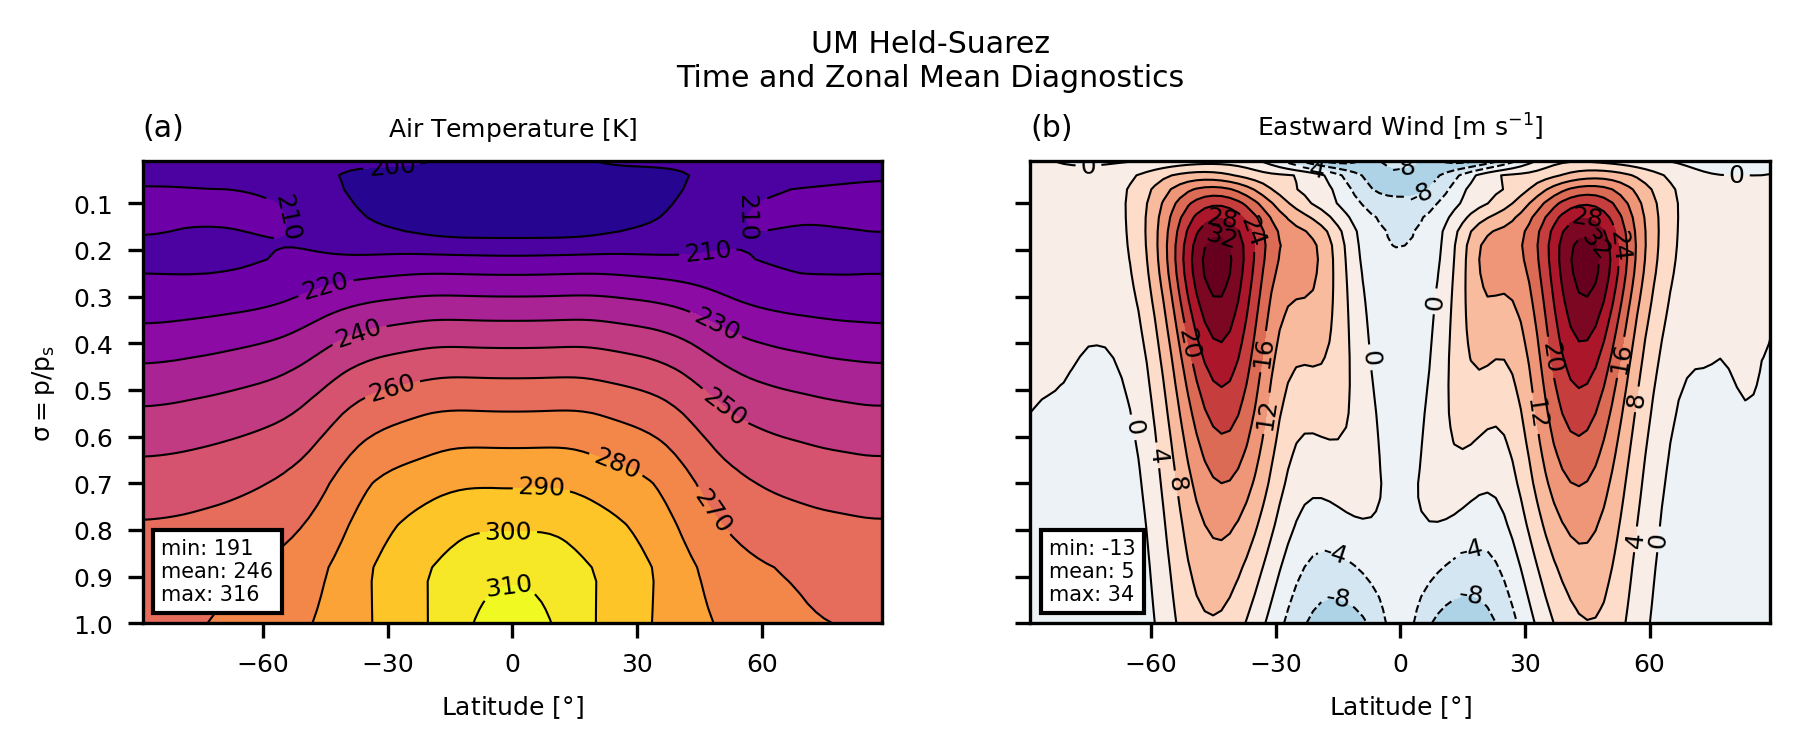

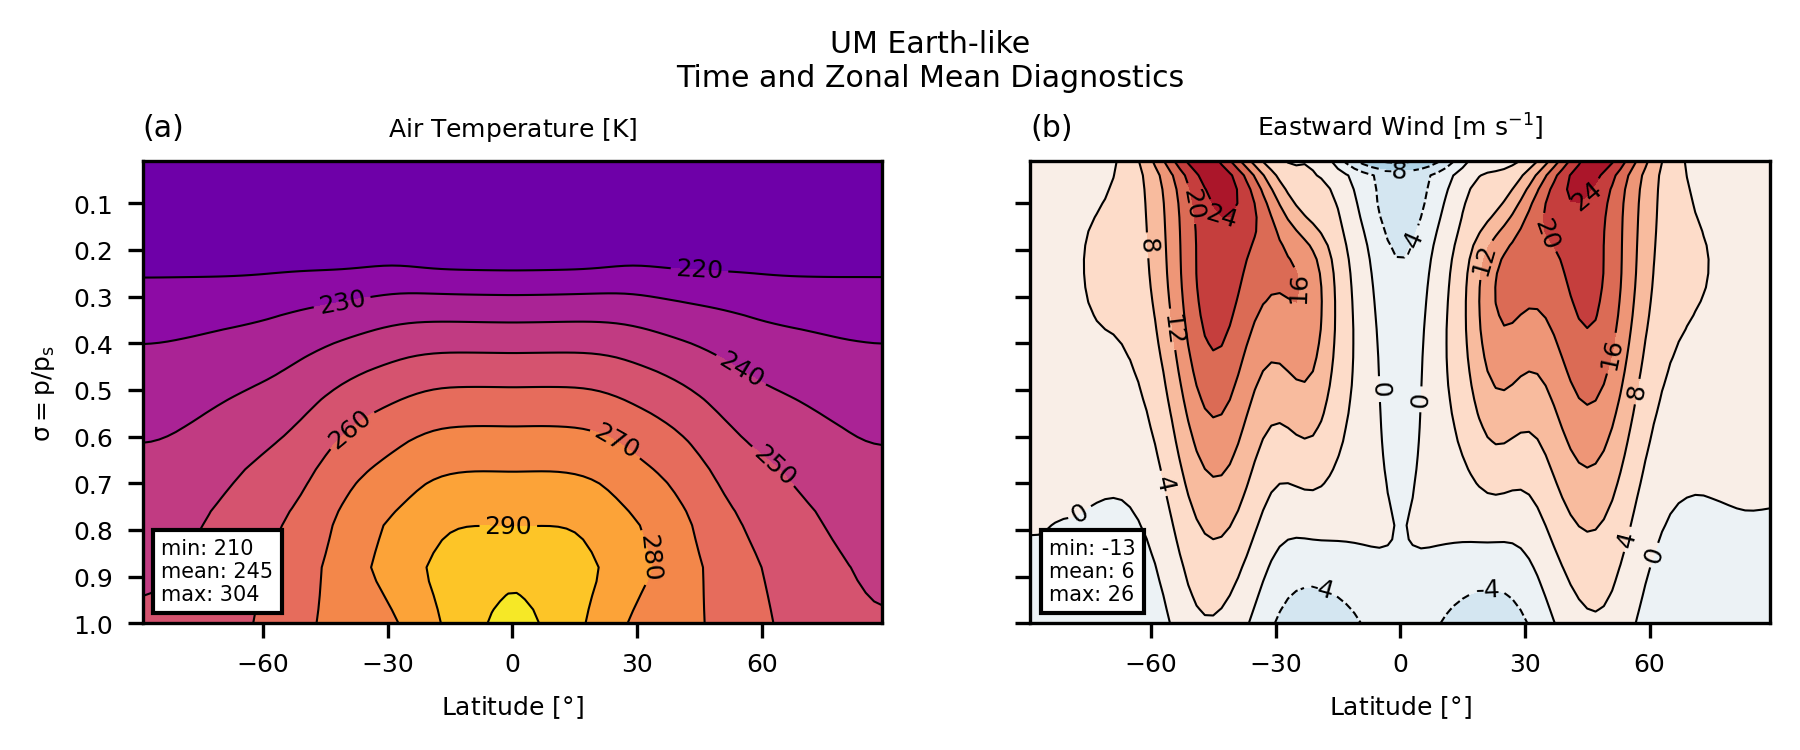

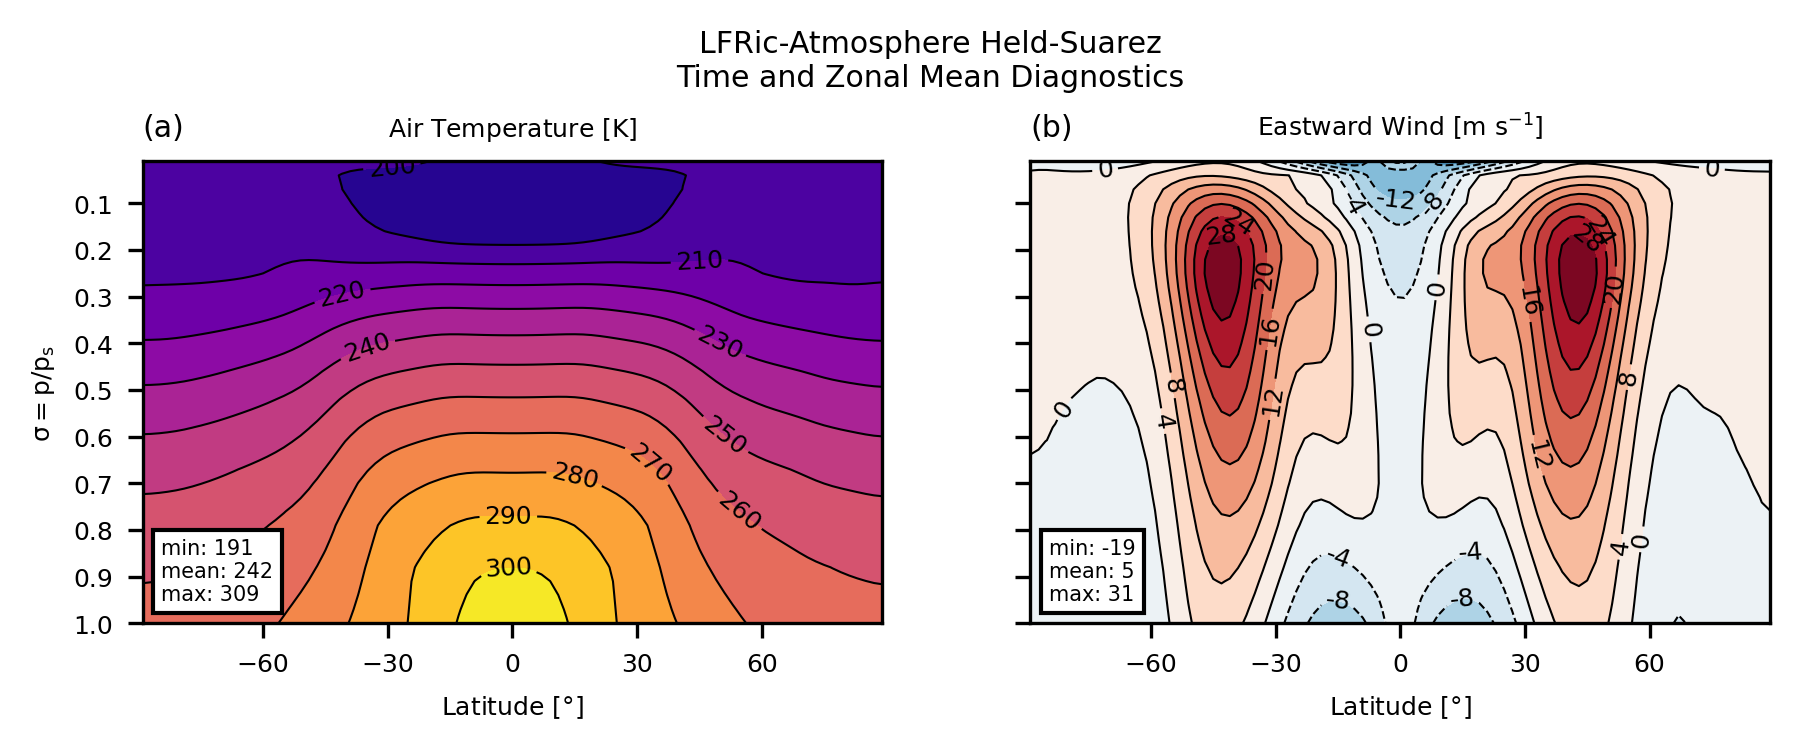

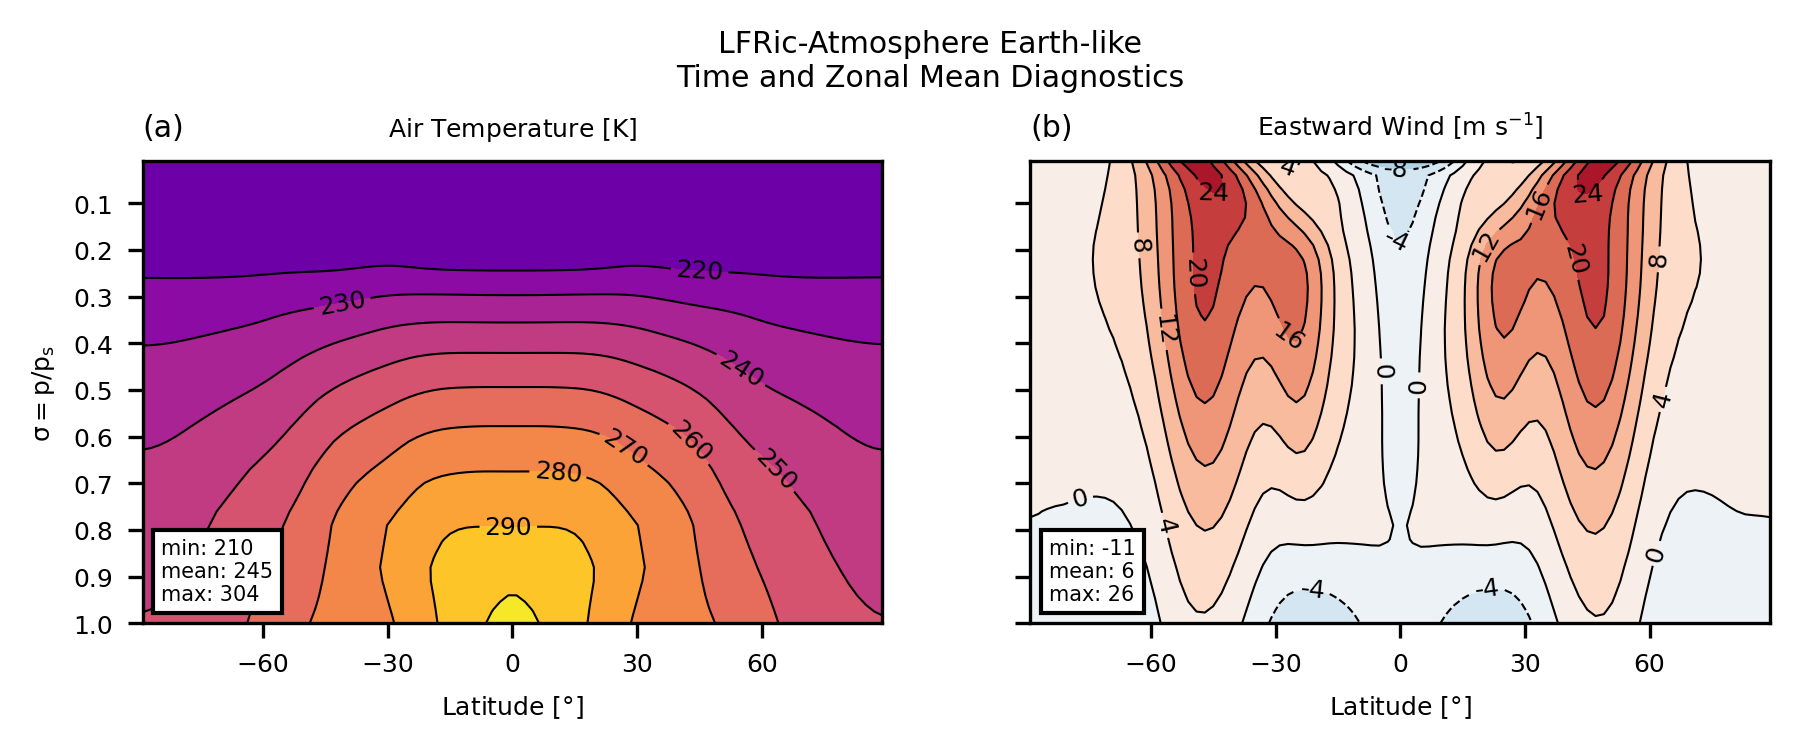

In [9]:
for model_key, model_prop in MODELS.items():
    model = model_prop["model"]

    for sim_label in ["hs", "el"]:
        sim_prop = TF_CASES[sim_label]

        fig = plt.figure(figsize=(7, 2))
        fig.suptitle(
            f"{model_prop['title']} {sim_prop['title']}\nTime and Zonal Mean Diagnostics",
            y=1.1,
        )
        axd = fig.subplot_mosaic(
            qplt.make_list_2d(DIAGS.keys(), ["lfric"]),
            gridspec_kw={"wspace": 0.2},
            sharex=True,
            sharey=True,
        )
        iletters = subplot_label_generator()
        for ax in axd.values():
            ax.set_title(f"({next(iletters)})", loc="left")
            ax.set_xticks(np.arange(-90, 91, 30))
            ax.set_yticks(np.arange(1.0, 0.0, -0.1))
            ax.set_ylim(itemgetter(0, -1)(SIGMA_LEVELS))
            ax.set_xlim(-89, 89)

            if ax.get_subplotspec().is_last_row():
                ax.set_xlabel("Latitude [$\degree$]")
            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel("$\sigma=p/p_s$")

        for diag_key, diag_prop in DIAGS.items():
            ax = axd[f"{diag_key}-lfric"]
            tex_units = diag_prop["tex_units"]
            ttl = diag_prop["title"]
            if tex_units != "1":
                ttl += f" [{tex_units}]"
            ax.set_title(ttl, size="medium", loc="center")
            # ax.set_title(model_prop["title"], size="medium", loc="right")

            cube = diag_prop["recipe"](runs_sigma_p[model_key][sim_label], model=model)
            cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
            x = cube.coord(lfric.y).points
            y = cube.coord(lfric.s).points
            z = cube.data

            plt_items = itemgetter("plt_method", "kw_plt", "add_colorbar", "add_clabel")
            for plt_method, kw_plt, add_colorbar, add_clabel in zip(
                *plt_items(diag_prop)
            ):
                pic = getattr(ax, plt_method)(x, y, z, **kw_plt)
                if add_colorbar:
                    fig.colorbar(pic, ax=ax)
                if add_clabel:
                    ax.clabel(pic, fmt="%.0f", use_clabeltext=True)
            if add_minmeanmax:
                ax.add_artist(
                    AnchoredText(
                        cube_minmeanmax_str(
                            cube, sep="\n", eq_sign=": ", fmt=fmt, weight=False
                        ),
                        loc="lower left",
                        frameon=True,
                        prop={"size": "small"},
                    )
                )
        figsave(
            fig,
            paths.figures
            / f"exf__{model_key}__{sim_label}__zm__{'_'.join(DIAGS.keys())}{postfix}",
        )

## Maps for the TLE case

Select only the Tidally Locked Earth case

In [10]:
sim_label = "tle"
sim_prop = TF_CASES[sim_label]

Define a function to collapse cubes

In [11]:
from aeolus.coord import nearest_coord_value

# day_start = 200
# day_end = 1200


def reduce_func(cube, s_lev):
    """Reduce cube to a 2D slice."""
    cube_slice = cube.extract(
        iris.Constraint(**{lfric.s: nearest_coord_value(cube, lfric.s, s_lev)})
    )
    # return between_day_mean(cube_slice, day_start, day_end)
    # return after_n_day_mean(cube_slice, day_start)
    return cube_slice

Define diagnostics and their metadata, also select the two $\sigma_p=p/p_{sfc}$ levels to plot

In [12]:
llev = 0.97
ulev = 0.225
postfix = ""
# postfix = f"__{day_start:04d}-{day_end:04d}d"
DIAGS = {
    "temp-llev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.temp), llev),
        "title": "Air Temperature",
        "tex_units": "$K$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "plasma", "levels": np.arange(270, 321, 10), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(200, 400, 10),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "temp-ulev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.temp), ulev),
        "title": "Air Temperature",
        "tex_units": "$K$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {
                "cmap": "plasma",
                "levels": np.arange(215, 223, 1),
                "extend": "both",
            },  # "levels": np.arange(227, 234, 1),
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(200, 400, 1),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "u-llev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.u), llev),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-36, 37, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "u-ulev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.u), ulev),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-36, 37, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "v-llev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.v), llev),
        "title": "Northward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-36, 37, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "v-ulev": {
        "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.v), ulev),
        "title": "Northward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-36, 37, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
}

In [13]:
add_minmeanmax = True
fmt = ".0f"

Assemble the plot

Saved to ../figures/exf__lfric__tle__temp-llev_temp-ulev_u-llev_u-ulev_v-llev_v-ulev.png


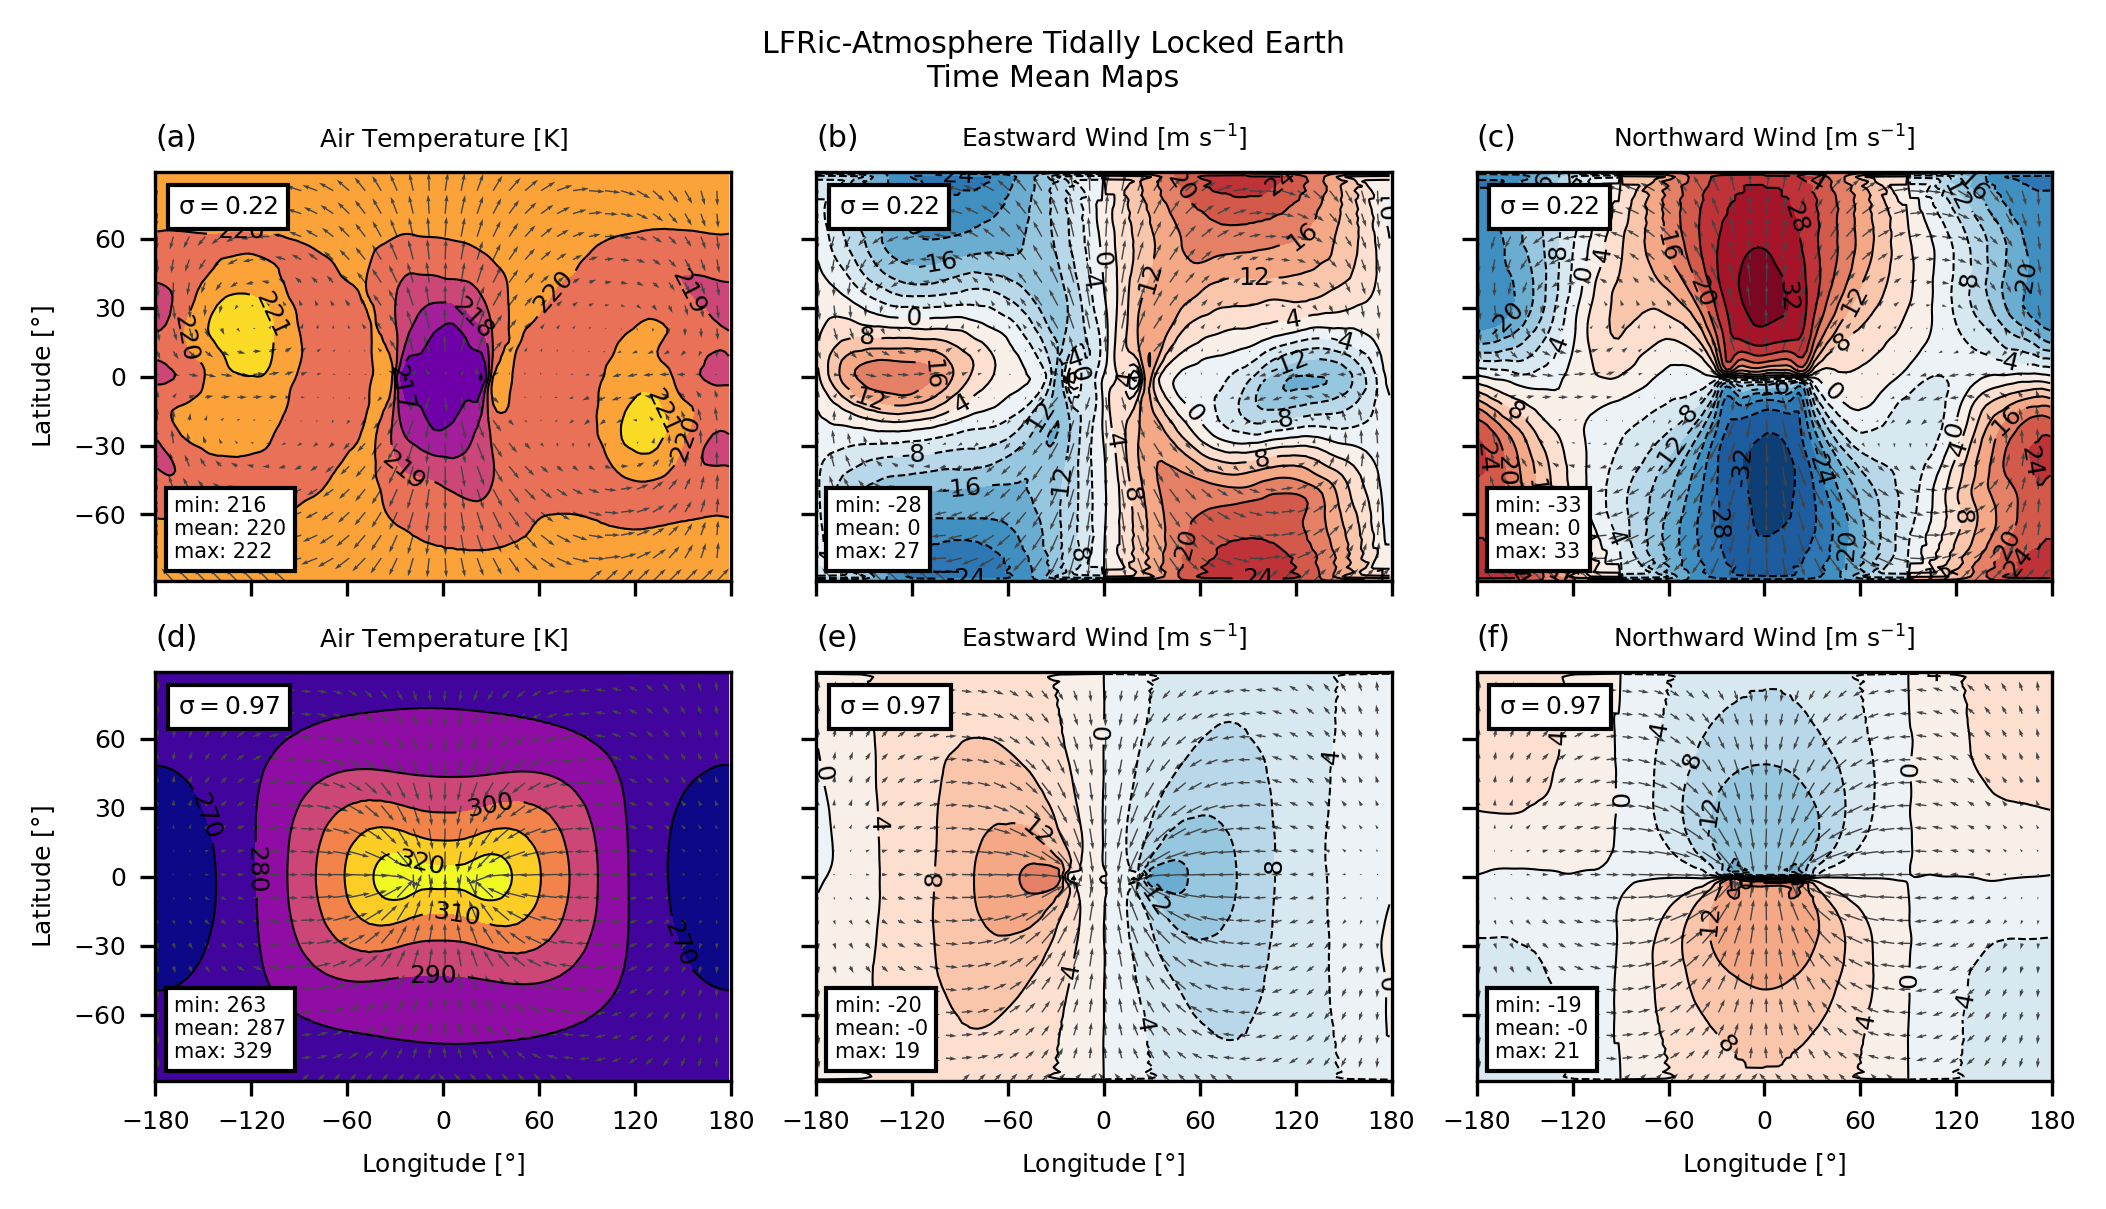

In [14]:
for model_key, model_prop in MODELS.items():
    if model_key != "lfric":
        continue
    model = model_prop["model"]

    fig = plt.figure(figsize=(7, 4), tight_layout=True)
    fig.suptitle(f"{model_prop['title']} {sim_prop['title']}\nTime Mean Maps", y=0.98)
    axd = fig.subplot_mosaic(
        qplt.make_list_2d(["temp", "u", "v"], ["ulev", "llev"]),
        # gridspec_kw={"wspace": 0.2},
        sharex=True,
        sharey=True,
    )
    iletters = subplot_label_generator()
    for ax_key, ax in axd.items():
        ax.set_title(f"({next(iletters)})", loc="left")
        ax.set_yticks(np.arange(-90, 91, 30))
        ax.set_ylim(-89, 89)
        ax.set_xticks(np.arange(-180, 181, 60))
        ax.set_xlim(-180, 180)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Longitude [$\degree$]")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Latitude [$\degree$]")

        diag_key = ax_key
        diag_prop = DIAGS[diag_key]

        tex_units = diag_prop["tex_units"]
        ttl = diag_prop["title"]
        if tex_units != "1":
            ttl += f" [{tex_units}]"
        ax.set_title(ttl, size="medium", loc="center")

        cube = diag_prop["recipe"](runs_sigma_p[model_key][sim_label], model=model)
        cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
        # cube = roll_cube_0_360(cube, model=lfric)

        x = cube.coord(lfric.x).points
        y = cube.coord(lfric.y).points
        z = cube.data
        if model_key == "um":
            z = np.roll(z, len(x) // 2, axis=-1)

        plt_items = itemgetter("plt_method", "kw_plt", "add_colorbar", "add_clabel")
        for plt_method, kw_plt, add_colorbar, add_clabel in zip(*plt_items(diag_prop)):
            pic = getattr(ax, plt_method)(x, y, z, **kw_plt)
            if add_colorbar:
                fig.colorbar(pic, ax=ax)
            if add_clabel:
                ax.clabel(pic, fmt="%.0f", use_clabeltext=True)
        ax.add_artist(
            AnchoredText(
                f"$\sigma={{{cube.coord(lfric.s).points[0]:.2f}}}$",
                loc="upper left",
                frameon=True,
            )
        )
        if add_minmeanmax:
            ax.add_artist(
                AnchoredText(
                    cube_minmeanmax_str(cube, sep="\n", eq_sign=": ", fmt=fmt),
                    loc="lower left",
                    frameon=True,
                    prop={"size": "small"},
                )
            )

        # Add quivers
        s_lev = cube.coord(lfric.s).points[0]
        u = reduce_func(runs_sigma_p[model_key][sim_label].extract_cube(model.u), s_lev)
        v = reduce_func(runs_sigma_p[model_key][sim_label].extract_cube(model.v), s_lev)
        xsl, ysl = slice(None, None, 4), slice(None, None, 5)
        ax.quiver(x[xsl], y[ysl], u.data[ysl, xsl], v.data[ysl, xsl], color="#444444")

    figsave(
        fig,
        paths.figures
        # / "drafts"
        / f"exf__{model_key}__{sim_label}__{'_'.join(DIAGS.keys())}{postfix}",
    )

In [ ]:
# postfix = "__mayne14_style"
# DIAGS = {
#     "temp": {
#         "recipe": lambda cl, model=lfric: zonal_mean(
#             after_n_day_mean(cl.extract_cube(model.temp), 200, model=model), model=model
#         ),
#         "title": "Air Temperature",
#         "tex_units": "$K$",
#         "plt_method": ["pcolormesh", "contour"],
#         "kw_plt": [
#             # {"cmap": "jet", "vmin": 192, "vmax": 303},
#             {"cmap": "jet", "vmin": 210, "vmax": 295},
#             {
#                 "cmap": "Greys",
#                 "linewidths": 0.5,
#                 "levels": np.arange(209, 300, 9),
#             },
#         ],
#         "add_colorbar": [False, False],
#         "add_clabel": [False, True],
#     },
#     "u": {
#         "recipe": lambda cl, model=lfric: zonal_mean(
#             after_n_day_mean(cl.extract_cube(model.u), 200, model=model), model=model
#         ),
#         "title": "Eastward Wind",
#         "tex_units": "$m$ $s^{-1}$",
#         "plt_method": ["pcolormesh", "contour"],
#         "kw_plt": [
#             {
#                 "cmap": "bwr",
#                 # "norm": mcol.TwoSlopeNorm(vcenter=0, vmin=-24.54, vmax=31.60),
#                 "norm": mcol.TwoSlopeNorm(vcenter=0, vmin=-9.13, vmax=21.37),
#             },
#             {
#                 "colors": "k",
#                 "linewidths": 0.5,
#                 # "levels": np.arange(-200, 200, 4),
#                 "levels": [3.6, 8.15, 12.7, 17.25],
#             },
#         ],
#         "add_colorbar": [False, False],
#         "add_clabel": [False, True],
#     },
# }

In [ ]:
# postfix = "__mayne14_style"
# DIAGS = {
#     "temp-llev": {
#         "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.temp), 0.97),
#         "title": "Air Temperature",
#         "tex_units": "$K$",
#         "plt_method": ["pcolormesh", "contour"],
#         "kw_plt": [
#             {"cmap": "jet", "vmin": 271,"vmax":332},
#             {
#                 "colors": "k",
#                 "linewidths": 0.5,
#                 "levels": np.arange(266, 400, 6),
#             },
#         ],
#         "add_colorbar": [False, False],
#         "add_clabel": [False, True],
#     },
#     "temp-ulev": {
#         "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.temp), ulev),
#         "title": "Air Temperature",
#         "tex_units": "$K$",
#         "plt_method": ["pcolormesh", "contour"],
#         "kw_plt": [
#             {"cmap": "jet"},  #
#             {
#                 "colors": "k",
#                 "linewidths": 0.5,
#                 "levels": np.arange(200, 400, 1),
#             },
#         ],
#         "add_colorbar": [False, False],
#         "add_clabel": [False, True],
#     },
#     "u-llev": {
#         "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.u), llev),
#         "title": "Eastward Wind",
#         "tex_units": "$m$ $s^{-1}$",
#         "plt_method": ["pcolormesh", "contour"],
#         "kw_plt": [
#             {"cmap": "bwr", "norm": mcol.TwoSlopeNorm(vcenter=0, vmin=-17.43, vmax=17.34)},
#             {
#                 "colors": "k",
#                 "linewidths": 0.5,
#                 "levels": np.arange(-200, 200, 5),
#             },
#         ],
#         "add_colorbar": [False, False],
#         "add_clabel": [False, True],
#     },
#     "u-ulev": {
#         "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.u), ulev),
#         "title": "Eastward Wind",
#         "tex_units": "$m$ $s^{-1}$",
#         "plt_method": ["pcolormesh", "contour"],
#         "kw_plt": [
#             {"cmap": "bwr", "norm": mcol.TwoSlopeNorm(vcenter=0, vmin=-30.75, vmax=29.81)},
#             {
#                 "colors": "k",
#                 "linewidths": 0.5,
#                 "levels": np.arange(-200, 200, 4),
#             },
#         ],
#         "add_colorbar": [False, False],
#         "add_clabel": [False, True],
#     },
#     "v-llev": {
#         "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.v), llev),
#         "title": "Northward Wind",
#         "tex_units": "$m$ $s^{-1}$",
#         "plt_method": ["pcolormesh", "contour"],
#         "kw_plt": [
#             {"cmap": "bwr", "norm": mcol.TwoSlopeNorm(vcenter=0, vmin=-40.25, vmax=38.77)},
#             {
#                 "colors": "k",
#                 "linewidths": 0.5,
#                 "levels": np.arange(-200, 200, 5),
#             },
#         ],
#         "add_colorbar": [False, False],
#         "add_clabel": [False, True],
#     },
#     "v-ulev": {
#         "recipe": lambda cl, model: reduce_func(cl.extract_cube(model.v), ulev),
#         "title": "Northward Wind",
#         "tex_units": "$m$ $s^{-1}$",
#         "plt_method": ["pcolormesh", "contour"],
#         "kw_plt": [
#             {"cmap": "bwr", "norm": mcol.TwoSlopeNorm(vcenter=0, vmin=-17.83, vmax=21.72)},
#             {
#                 "colors": "k",
#                 "linewidths": 0.5,
#                 "levels": np.arange(-200, 200, 5),
#             },
#         ],
#         "add_colorbar": [False, False],
#         "add_clabel": [False, True],
#     },
# }

## Meridional section

In [ ]:
interp_to_equator = lambda cube, model=lfric: cube.interpolate(
    [(model.y, 0)], iris.analysis.Linear()
)

In [ ]:
DIAGS = {
    "temp": {
        "recipe": lambda cl, model=lfric: interp_to_equator(
            after_n_day_mean(
                cl.extract_cube(model.temp),
                200,
                model=model,
            )
        ),
        "title": "Air Temperature",
        "tex_units": "$K$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "plasma", "levels": np.arange(190, 311, 10), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(200, 400, 10),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "u": {
        "recipe": lambda cl, model=lfric: interp_to_equator(
            after_n_day_mean(cl.extract_cube(model.u), 200, model=model), model=model
        ),
        "title": "Eastward Wind",
        "tex_units": "$m$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": np.arange(-32, 33, 4), "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 4),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
    "w": {
        "recipe": lambda cl, model=lfric: interp_to_equator(
            after_n_day_mean(cl.extract_cube(model.w), 200, model=model), model=model
        ),
        "title": "Vertical Wind",
        "tex_units": "$cm$ $s^{-1}$",
        "plt_method": ["contourf", "contour"],
        "kw_plt": [
            {"cmap": "RdBu_r", "levels": linspace_pm1(3) * 30, "extend": "both"},
            {
                "colors": "k",
                "linewidths": 0.5,
                "levels": np.arange(-200, 200, 10),
            },
        ],
        "add_colorbar": [False, False],
        "add_clabel": [False, True],
    },
}

### Plot all cases

In [ ]:
for sim_label in ["tle", "tle_dlayer_off", "tle_dl_type_standard"]:
    sim_prop = SIM_CASES[sim_label]

    fig = plt.figure(figsize=(7, 2))
    fig.suptitle(
        f"{sim_prop['title']} Test\nTemporal and Zonal Mean Diagnostics", y=1.1
    )
    axd = fig.subplot_mosaic(
        qplt.make_list_2d(DIAGS.keys(), ["lfric"]),
        gridspec_kw={"wspace": 0.2},
        sharex=True,
        sharey=True,
    )
    iletters = subplot_label_generator()
    for ax in axd.values():
        ax.set_title(f"({next(iletters)})", loc="left")
        ax.set_xticks(np.arange(-180, 181, 60))
        ax.set_xlim(-180, 180)
        ax.set_yticks(np.arange(1.0, 0.0, -0.1))
        ax.set_ylim(itemgetter(0, -1)(sigma_levels))

        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Longitude [$\degree$]")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("$\sigma=p/p_s$")

    for diag_key, diag_prop in DIAGS.items():
        ax = axd[f"{diag_key}-lfric"]
        tex_units = diag_prop["tex_units"]
        ttl = diag_prop["title"]
        if tex_units != "1":
            ttl += f" [{tex_units}]"
        ax.set_title(ttl, size="medium", loc="center")
        # ax.set_title(model_prop["title"], size="medium", loc="right")

        cube = diag_prop["recipe"](runs_sigma_p[sim_label], model=lfric)
        cube.convert_units(tex2cf_units(diag_prop["tex_units"]))
        x = cube.coord(lfric.x).points
        y = cube.coord(lfric.s).points
        z = cube.data

        plt_items = itemgetter("plt_method", "kw_plt", "add_colorbar", "add_clabel")
        for plt_method, kw_plt, add_colorbar, add_clabel in zip(*plt_items(diag_prop)):
            pic = getattr(ax, plt_method)(x, y, z, **kw_plt)
            if add_colorbar:
                fig.colorbar(pic, ax=ax)
            if add_clabel:
                ax.clabel(pic, fmt="%.0f", use_clabeltext=True)
    figsave(
        fig,
        paths.figures
        / "drafts"
        / f"exf__lfric__{sim_label}__eq_sec__{'_'.join(DIAGS.keys())}",
    )

---

## TL coordinates

In [ ]:
from aeolus.calc import (
    cumsum,
    regrid_to_tidally_locked_coordinates,
    rotate_winds_to_tidally_locked_coordinates,
)
from aeolus.calc.diag import lat_cos
from aeolus.meta import const_from_attrs, update_metadata
from iris.util import reverse


@const_from_attrs()
@update_metadata(name="tidally_locked_mass_streamfunction", units="kg s^-1")
def tidally_locked_mass_streamfunction(
    u, v, p_sfc=None, const=None, pole_lon=0, pole_lat=0, model=um
):
    """Mass streamfunction in tidally locked coordinates."""
    const_factor = 2 * np.pi * const.radius
    # Sigma-pressure coordinates
    _, v_tl_cube = rotate_winds_to_tidally_locked_coordinates(
        u, v, pole_lon=pole_lon, pole_lat=pole_lat
    )
    v_tl_cube = regrid_to_tidally_locked_coordinates(
        v_tl_cube, pole_lon=pole_lon, pole_lat=pole_lat
    )
    p_sfc_tl_cube = regrid_to_tidally_locked_coordinates(
        p_sfc, pole_lon=pole_lon, pole_lat=pole_lat
    )
    p_sfc_v_tl_zm = zonal_mean(v_tl_cube * p_sfc_tl_cube)

    sf_tl = reverse(
        cumsum(reverse(p_sfc_v_tl_zm, lfric.s), "s", axis_weights=True, model=lfric),
        lfric.s,
    )
    sf_tl *= const_factor * lat_cos(sf_tl) / const.gravity

    return sf_tl

In [ ]:
sim_label = "tle"
sim_prop = SIM_CASES[sim_label]
the_run = runs_sigma_p[sim_label]
const = init_const(sim_prop["planet"], directory=paths.const)

In [ ]:
u = runs_sigma_p[sim_label].extract_cube(lfric.u)
v = runs_sigma_p[sim_label].extract_cube(lfric.v)
p_sfc = runs[sim_label].pres.extract(iris.Constraint(**{lfric.z: 0}))
pole_lon = 180

In [ ]:
tl_sf = tidally_locked_mass_streamfunction(u, v, p_sfc, pole_lon=pole_lon)

In [ ]:
plt.contourf(after_n_day_mean(tl_sf, 200).data)
plt.colorbar()